In [1020]:
import json
from collections import defaultdict
import re
import random
import string
import math
import numpy as np
from operator import itemgetter 


In [1021]:
def ingredient_exists(ingredient,list):
    for elem in list:
        if ingredient['name'] == elem['name']:
            return True
    return False

In [1022]:
recipes = []
bow = defaultdict(int)
roles = defaultdict(set)
ingredient_inverse = defaultdict(int)
ingredients_total = set()
ingredients_total_full = []
filtered = defaultdict(int)

counter = 0
with open('./data.json') as json_file:
    data = json.load(json_file)
    for p in data:
        recipes.append(p)
        for word in p['instructions'].lower().split(' '):
            bow[word] +=1


        
        for ing in p['ingredients']:
            ingredients_total.add(ing['name'])
            if not ingredient_exists(ing,ingredients_total_full):
                ingredients_total_full.append(ing)
            if 'role' not in ing: # remove this
                continue
            roles[ing['role']].add(ing['name'])

        
        for word_ing in ingredients_total:
            if word_ing in p['instructions']:
                filtered[word_ing] +=1



bow = {k: v for k, v in sorted(bow.items(), key=lambda item: item[1], reverse=True)}
filtered = {k: v for k, v in sorted(filtered.items(), key=lambda item: item[1], reverse=True)}



In [1023]:
import networkx as nx


def calc_graph(population):
    G = nx.Graph()
    for individual in population:
        for idx in range(len(individual['ingredients']) -1):
            for idx2 in range(idx + 1, len(individual['ingredients'])):
                #print(individual['ingredients'][idx])
                G.add_edge(individual['ingredients'][idx]['name'], individual['ingredients'][idx2]['name'])

    return G




In [1024]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [recipe['title'] for recipe in recipes]
corpus_index = {k: v for k, v in enumerate(corpus)}
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [1025]:
for k ,v  in filtered.items():
    print("{} -> {}/{}".format(k, v, len(recipes)))

egg -> 1295/1668
sugar -> 1295/1668
flour -> 1266/1668
butter -> 1163/1668
salt -> 953/1668
vanilla -> 908/1668
baking soda -> 825/1668
cream -> 727/1668
brown sugar -> 508/1668
baking powder -> 468/1668
white sugar -> 397/1668
milk -> 335/1668
shortening -> 330/1668
chocolate chip -> 314/1668
oat -> 271/1668
vanilla extract -> 266/1668
margarine -> 245/1668
cinnamon -> 237/1668
walnut -> 220/1668
water -> 217/1668
confectioners' sugar -> 214/1668
chocolate -> 170/1668
peanut butter -> 162/1668
raisin -> 145/1668
coconut -> 142/1668
peanut -> 122/1668
butter or margarine -> 118/1668
cocoa -> 99/1668
nutmeg -> 82/1668
egg white -> 78/1668
almond -> 72/1668
lemon -> 70/1668
egg yolk -> 66/1668
almond extract -> 66/1668
cocoa powder -> 59/1668
cream of tartar -> 57/1668
honey -> 53/1668
apple -> 51/1668
cream cheese -> 50/1668
white chocolate -> 48/1668
rum -> 48/1668
ginger -> 47/1668
rolled oat -> 46/1668
vegetable oil -> 42/1668
oatmeal -> 42/1668
date -> 38/1668
sour cream -> 37/1668


In [1026]:
bow

{'the': 8023,
 'and': 7233,
 'to': 5413,
 'in': 5363,
 'a': 4445,
 'until': 3452,
 'degrees': 3193,
 'baking': 2681,
 'into': 2175,
 'oven': 1933,
 'on': 1887,
 'for': 1862,
 'with': 1770,
 'cookie': 1769,
 'stir': 1656,
 'dough': 1616,
 'f': 1564,
 'of': 1500,
 'together': 1411,
 'cool': 1339,
 'cookies': 1261,
 'sugar': 1199,
 'add': 1153,
 'minutes': 1140,
 'mix': 1140,
 'beat': 1089,
 'preheat': 1074,
 'butter': 1052,
 'flour,': 1037,
 'or': 993,
 '1': 983,
 'onto': 972,
 '350': 927,
 'preheated': 920,
 '2': 918,
 'mixture': 875,
 'bowl,': 855,
 '10': 842,
 'at': 837,
 'large': 817,
 '(175': 803,
 'about': 766,
 'cream': 744,
 'chocolate': 733,
 'place': 715,
 'sugar,': 708,
 'c).': 700,
 'wire': 698,
 'flour': 696,
 'by': 652,
 'brown': 605,
 'vanilla': 592,
 'lightly': 582,
 'sheet': 563,
 'minutes.': 562,
 'each': 545,
 'inches': 542,
 'roll': 539,
 'an': 539,
 'egg': 532,
 'white': 526,
 'bowl': 518,
 'are': 511,
 'before': 510,
 'butter,': 508,
 'inch': 501,
 'bake': 495,
 'so

Some of the functions used in the project need to compare ingredients with diferent units. (e.g. the fitness function). In order to make it easier we aproximate every type of measure to cups.(the most common measure used in the recipes)

In [1027]:
cup_equivalent = {
    'cup':1.0,
    'cups':1.0,
    'package':3.0,#random
    'packages': 3.0,
    'box': 4.0,#random
    'boxes': 4.0,
    'tablespoon':0.0625,
    'tablespoons':0.0625,
    'teaspoon': 0.02,
    'teaspoons': 0.02,
    'pound':3.5,
    'pounds':3.5,
    'pint':2.0,
    'pints':2.0,
    'jar':2.0,
    'jars':2.0,
    'stick':0.5,
    'sticks':0.5,
    'quart': 4,
    'quarts':4,
    'ounce':0.125,
    'ounces':0.125,
    'fluid': 0.125, #fluid ounces
    'fluids':0.125,
    'pinch': 0.001,
    'can':0.1,
    'units':1.0,
}
def quantity_norm(ingredient):
    if ingredient['measure'] not in cup_equivalent:
        #print(ingredient['measure'])
        return float(ingredient['quantity'])
    return float(ingredient['quantity']) * cup_equivalent[ingredient['measure']]

For the fitness function we wanted to encourage interesting recipes and ingredients, while keeping the recipes with the type of ingredients necessary to make it work. We used the following article, [How Ingredients Behave In A Cookie Recipe](https://www.instructables.com/How-Ingredients-Behave-In-A-Cookie-Recipe/), to get some insight on how different roles of ingredients interact to form the final cookie. The article mentions mandatory rules that apply to the making of every cookie: 
- "The rule of thumb for cookie baking is to always keep the amount of fat and sugar used relatively equal. There should be less than 1/4 cup difference between the two" - One of the fitness parameters for the recipes is how similiar are the fat and sugar quantities of the recipe
- "The amount of flour used should be about two times the amount of fat" - The second fitness parameter

- "The foundation of any cookie recipe consists of five types of ingredients: fat, sugar, flour, a rising agent, and a binding agent." - Another fitness parameter, every cookie should have at least one ingredient in each essential role.

To make the recipe interesting and believable we also want to limit the number of the flavoring ingredients by having a lower and upper limit. If the recipe steps outside the boundary this fitness parameter is reduced based on how much it is out of the boundary.
Since we are dealing with cookie recipes, they should be somewhat simple and not have too many total ingredients

To make the recipe interesting, rare items are encouradged by having a fitness parameter that is based on the average rarity of all the ingredients.

All this parameters have a multiplier that can be tuned to change how much each fitness parameter affects the final fitness score


In [1028]:
def total_quantity_role(ingredients,role):
    total = 0
    for ingredient in ingredients:
        if ingredient['role'] == role:
            total += quantity_norm(ingredient)
    return total
def total_number_role(ingredients,role):
    total = 0
    for ingredient in ingredients:
        if ingredient['role'] == role:
            total += 1
    return total
def calc_num_essential_roles(ingredients):
    ess_roles = set()
    for ingredient in ingredients:
        if not ingredient['role'] == 'flavor texture':
            ess_roles.add(ingredient['role'])
    return len(ess_roles) 
def calc_avg_novelty(ingredients):
    total = 0
    for ingredient in ingredients:
        for key,value in filtered.items():
            if key in ingredient['name']:
                total = total +  (1/value)
                #print(1/value)
                break
    #print('total: ',total)
    return total / len(ingredients)


In [1029]:
def fitness(recipe):
    fat_sugar_balance_mult = .3
    fat_sugar_flour_mult = .3
    essential_roles_mul = 1
    min_number_flavoring_ingredients_mul = .3
    max_number_flavoring_ingredients_mul = .3
    max_number_ingredients_mul = 1
    avg_novelty_mul = 1.1

    ingredients = recipe['ingredients']
    num_ingredients = len(ingredients)

    num_essential_roles = calc_num_essential_roles(ingredients)
    number_flavoring_ingredients = total_number_role(ingredients,'flavor texture')
    total_sugar = total_quantity_role(ingredients,'sugar')
    total_fat = total_quantity_role(ingredients,'fat')
    total_flour = total_quantity_role(ingredients,'flour')
    
    fat_sugar_balance_fir = 0 if total_sugar+total_fat == 0 else (1 - abs(total_sugar-total_fat)/(total_sugar+total_fat))       #1
    fat_sugar_flour_fit = 0 if total_flour+total_fat == 0 else (1 - abs(total_flour-total_fat * 2)/(total_flour+total_fat * 2)) #2
    essential_roles_fit = num_essential_roles/5 #3

    min_number_flavoring_ingredients_fit = 1 if number_flavoring_ingredients >=2 else   (1 - abs(2-number_flavoring_ingredients)/(2+number_flavoring_ingredients))  #4
    max_number_flavoring_ingredients_fit = 1 if number_flavoring_ingredients <=5 else   (1 - abs(5-number_flavoring_ingredients)/(5+number_flavoring_ingredients))  #4
    max_number_ingredients_fit = 1 if num_ingredients <=10 else   (1 - abs(10-num_ingredients)/(10+num_ingredients))        #4.5

    
    avg_novelty_fit = calc_avg_novelty(ingredients) # 5
    fitness_score = (
                       fat_sugar_balance_fir * fat_sugar_balance_mult  
                     + fat_sugar_flour_fit * fat_sugar_flour_mult
                     + essential_roles_fit * essential_roles_mul
                     + min_number_flavoring_ingredients_fit * min_number_flavoring_ingredients_mul
                     + max_number_flavoring_ingredients_fit * max_number_flavoring_ingredients_mul
                     + max_number_ingredients_fit * max_number_ingredients_mul
                     + avg_novelty_fit * avg_novelty_mul
                     )
    fitness_score = round(fitness_score * 100)
    recipe['fitness'] = fitness_score
    #if fitness_score > 1000:
      #print(number_flavoring_ingredients_fit)
    #print(fitness_score)
    #print(fat_sugar_balance_fir,fat_sugar_flour_fit,number_flavoring_ingredients_fit,avg_novelty_fit)
    return fitness_score


In [1030]:
#re ={'title': 'VRKqObDCiQKrmywSdMse', 'ingredients': [{'measure': 'can', 'name': 'allspice', 'role': 'flavor texture', 'quantity': 1.7}], 'fitness': 8373}
#fitness(re)


We gave generated recipes two different properties in order to classify them and give more information about them in the recipe book. The following properties were defined: Crunchiness and Spread. These were calculated based on the following observations made in the previously mentioned [website](https://www.instructables.com/How-Ingredients-Behave-In-A-Cookie-Recipe/): 
1. "Fat is added for flavor and controls how chewy or crunchy the cookie is. More fat = a chewier cookie, less fat = a crunchier cookie." 
2. "Sugar is a sweetener (obviously!) and tenderizer, while controlling how much the cookie spreads. Adding sugar increases the spread of a cookie, so cookies with less sugar will be puffier. "


In [1031]:
def recipe_properties(recipe):
    ingredients = recipe['ingredients']
    total_sugar = total_quantity_role(ingredients,'sugar')
    total_fat = total_quantity_role(ingredients,'fat')
    total_flour = total_quantity_role(ingredients,'flour')
    recipe['properties'] = {}
    fat_to_others_ratio = 0 if total_sugar+total_fat+total_flour == 0 else (total_fat)/(total_sugar+total_fat+total_flour) #0.1-0.3
    sugar_to_others_ratio = 0 if total_sugar+total_fat+total_flour == 0 else (total_sugar)/(total_sugar+total_fat+total_flour) #0.2-0.4
    if fat_to_others_ratio <= 0.22:
        recipe['properties']['crunchiness'] = 'chewey'
    elif fat_to_others_ratio <= 0.25:
        recipe['properties']['crunchiness'] = 'normal'
    else: 
        recipe['properties']['crunchiness'] = 'crunchy'

    if sugar_to_others_ratio <= 0.22:
        recipe['properties']['spread'] = 'low'
    elif sugar_to_others_ratio <= 0.25:
        recipe['properties']['spread'] = 'normal'
    else: 
        recipe['properties']['spread'] = 'high'
    #print('not: ',total_sugar + total_flour,'fat: ',total_fat)
    #print('fat: ',fat_to_others_ratio)
    #print('sug: ',sugar_to_others_ratio)
    #print(recipe)

The creation of instructions takes into account two individual instructions selected from the population and the order of the ingredients added is relevant. The template method is used to create a new of instructions.
First of all, a regex to find the temperature to preheat the oven is used. Three different situations can happen: if both recipes do not have that instruction then the new created will not have as well; if only one has it, then the new recipe is going to use that temperature; if both have then a random temperature between the two is going to be selected uniformly. 
Then, we take the new recipe and use a template to build the new steps. According to a site, the ingredients that play the role of fat and sugar should be added first. Then, the ingredients that are flour, rising or binding agent are added, and lastly, the flavor textures. 
Finally, a regex is used to get the amount of time the cookies should be in the oven. This value can either be an interval or a single value depending on the instructions of the parent's recipes.

In [1032]:
def separate_enumeration(a):
    if len(a) > 1:
        instruction = ', '.join(a[:-1]) + ' and '  + a[-1] 
    else:
        instruction =  a[0]
    return instruction

In [1033]:
# does not have quantities
def crossover_instructions(recipe1, recipe2, ingredients_final):

    # preheating
    regex ='preheat (\w+\s)+(\d+)\sdegrees F'
    result1 = re.search(regex, recipe1['instructions'],  re.IGNORECASE | re.MULTILINE)
    result2 = re.search(regex, recipe2['instructions'],  re.IGNORECASE | re.MULTILINE)

    
    temp1 = -1
    temp2 = -1

    if result1 != None:
        temp1 = int(result1.group(2))
    if result2 != None:
        temp2 = int(result2.group(2))

    if temp1 !=-1 and temp2 !=-1:
        temp = round(random.uniform(temp1, temp2),0)
    elif temp1 != -1:
        temp = temp1
    else:
        temp = temp2

    if temp != - 1:
        first_step = "Preheat the oven at " + str(temp) + " F degrees."
    else:
        first_step = ''
    # add fat and sugar
    first = []
    second = []
    third = []

    for ingredient in ingredients_final:
        if ingredient['role'] == 'fat' or ingredient['role'] == 'sugar':
            first.append(ingredient['name'])
        #flour, rising agent, binding agent
        elif ingredient['role'] == 'flour' or ingredient['role'] == 'rising agent' or ingredient['role'] == 'binding agent':
            second.append(ingredient['name'])
        # add flavour texture
        else:
            third.append(ingredient['name'])


    second_step = 'Add ' + separate_enumeration(first) + '. '
    second_step += 'Then add ' + separate_enumeration(second) + '. '
    second_step += 'Finally, join the following flavour textures: ' + separate_enumeration(third) +'. '


    # baking
    lower = 10000
    upper = -1
    regex2 = '((\d+) to)? (\d+) minutes'
    times1 = re.search(regex2, recipe1['instructions'],  re.IGNORECASE | re.MULTILINE)
    if times1 != None:
        #print(times1.groups())
        if times1.group(1) == None:
            lower = min(int(times1.group(3)),lower)
            upper = max(int(times1.group(3)), upper)

        else:
            lower = min(int(times1.group(2)), lower)
            upper = max(int(times1.group(3)), upper)

    times2 = re.search(regex2, recipe2['instructions'],  re.IGNORECASE | re.MULTILINE)

    if times2 != None:
        #print(times2.groups())
        if times2.group(1) == None:
            lower = min(int(times2.group(3)), lower)
            upper = max(int(times2.group(3)), upper)
        else:
            lower = min(int(times2.group(2)), lower)
            upper = max(int(times2.group(3)), upper)



    third_step = "Put the dough in the oven from " + str(lower) + " to " + str(upper) + " minutes. Take it from the oven and let it cool down."
    #print(third_step)
    return first_step + os.linesep + second_step + os.linesep + third_step


The creation of the title takes into account the titles to crossover, and the new set of ingredients of the new recipe, since the title may contain the name of ingredients that do not exist in this new set. First of all, TF-IDF is used in the titles of the current population (parent recipes) in order to know which words are more relevant. For each title, we take one word which is an ingredient and has the highest score of them. Then for the other words, a priority queue for each title is used and ordered according to the value of the TF-IDF. Then, to decide on how many of those words are going to be in the title, we get a random number generated through a uniform distribution that is limited in the range of  [1, priority_queue.length()]. Moreover, if both titles have common words, then it is guaranteed that these words are going to be in the title unless they are ingredients that are not presented in the new recipe. Subsequently, a final check to see if there are repeated words is done. The title puts, in the beginning, the common words that both may have since it may contain adjectives, then the ingredients, and at the end, the word 'cookies' is placed. Finally, the word 'cookies' is added to the end.

In [1034]:
def merge_titles(index1, index2, ingredients_new_recipe, recipes, roles, vectorizer, X ):

    ingredients_new_recipe = [x['name'].lower() for x in ingredients_new_recipe]
    #print(ingredients_new_recipe)

    feature_names = vectorizer.get_feature_names()
    feature_index = X[index1,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[index1, x] for x in feature_index])
    
    pq = set()
    name1 = ''
    first_high_score = -1
    first_characteristics = []

    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if w == 'cookies':
            continue

        first_characteristics.append(w)
        for ing in ingredients_new_recipe:
            if w in ing and first_high_score < s: #and w in naming_ingredients: 
                #print(w)
                name1 = w 
                
            else:
                if w != 'cookies': 
                    pq.add((s, w))


    #print("---")
    common_characteristics = []
    pq2 = set()
    name2 = ''
    second_high_score = -1
    feature_index = X[index2,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[index2, x] for x in feature_index])


    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:

        if w == 'cookies':
            continue

        if w in first_characteristics and w != 'cookies' and  (\
        (w not in ingredients_total and w not in ingredients_new_recipe)  or\
        (w not in ingredients_new_recipe and w not in ingredients_new_recipe)\
        ):            common_characteristics.append(w)

        for ing in ingredients_new_recipe:
            if w in ing and second_high_score < s: #and w in naming_ingredients:
                #print(w)
                name2 = w
            else: 
                if w != 'cookies': 
                    pq2.add((s, w))

    pq2 = list(pq2)
    pq = list(pq)

    sorted(pq, reverse=True)
    sorted(pq2, reverse=True)


    extract1 =  min(abs(math.floor(np.random.uniform(0, len(pq)))), len(pq))
    extract2 =  min(abs(math.floor(np.random.uniform(0, len(pq2)))), len(pq2))

    list1 = [item[1] for item in pq ][:extract1]
    list2 = [item[1] for item in pq ][:extract2]


    #print( max(min(math.floor(0, np.random.normal(len(pq)), len(pq)), 1)))


    words = set([name1, name2, *common_characteristics,  * list1,  *list2])
    extra = []
    if len(words) <= 3:
        naming_ingredients = roles['flavor texture']
        x = naming_ingredients & set(ingredients_new_recipe)
        #print(len(x)/2)
        extra = random.sample(x, int(len(x)/2 ))  
        
    words.update(extra)
    words.discard('')

    words =  ' '.join(words) + ' cookies'

    return words
####

'''
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

corpus = [recipe['title'].lower() for recipe in recipes]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)



merge_titles(2, 9, recipes[5]['ingredients'], recipes, roles, vectorizer, X)
#print(recipes[3]['title'].lower())
#print(recipes[5]['title'].lower())#

#
# (3, 5, recipes[3]['ingredients'], recipes, roles)
'''

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nimport numpy as np\n\ncorpus = [recipe['title'].lower() for recipe in recipes]\nvectorizer = TfidfVectorizer()\nX = vectorizer.fit_transform(corpus)\n\n\n\nmerge_titles(2, 9, recipes[5]['ingredients'], recipes, roles, vectorizer, X)\n#print(recipes[3]['title'].lower())\n#print(recipes[5]['title'].lower())#\n\n#\n# (3, 5, recipes[3]['ingredients'], recipes, roles)\n"

The generation of a new set of ingredients takes into consideration two different recipes and the roles each ingredient plays. First of all, the ingredients are grouped by roles per recipe. Then, to build a new set of ingredients, it is ensured that the roles persist in the new recipe. If only one recipe has an ingredient for one role then, the ingredient is maintained, if both recipes have 1 ingredient for a role, then one of them is chosen randomly. Lastly, for other cases, it is taken randomly half of the ingredients of each recipe for each role.

In [1035]:

# todo: quantities are missing
def crossover(recipe1, recipe2,population):
    ingredients1 = defaultdict(list)
    ingredients2 = defaultdict(list)
    roles_set = set()
    
    for ingredient in recipe1['ingredients']:
        roles_set.add(ingredient['role'])
        ingredients1[ingredient['role']].append(ingredient)
    for ingredient in recipe2['ingredients']:
        roles_set.add(ingredient['role'])
        ingredients2[ingredient['role']].append(ingredient)


    new_recipe = {}
    #new_recipe['title'] = ''.join(random.choice(string.ascii_letters) for i in range((int( (len(recipe1['title']) + len(recipe2['title']))/2))))
    new_recipe['ingredients'] = []
    for role in roles_set:  
        nr1 = len(ingredients1[role])
        nr2 = len(ingredients2[role])
        
        if nr1 == 1 and nr2 == 1: #choose from one group
            r1 = random.randint(0, 1)
            if r1 == 0:
                new_recipe['ingredients'].append(ingredients2[role][0])
            else :
                new_recipe['ingredients'].append(ingredients2[role][0])

        elif nr1 + nr2 == 1:
            merged = ingredients1[role] + ingredients2[role]
            new_recipe['ingredients'].append(merged[0])

        else: # take more and less half of each

            #print(n1,n2)
            #indexes1=np.random.randint(0,nr1 ,math.ceil(nr1/2))
            indexes1 = random.sample(range(nr1),math.ceil(nr1/2))
            #print(indexes1)
            l1 = list(map(ingredients1[role].__getitem__, indexes1))
            indexes2 = random.sample(range(nr2),math.ceil(nr2/2))
            #print(indexes2)
           # indexes2= 0 if nr2 == 0 else np.random.randint(0,nr2 ,math.ceil(nr1/2))
            l2 = list(map(ingredients2[role].__getitem__, indexes2))
            #print(l1,l2)
            #s = set(l1 + l2)
            for ing in l1:
                new_recipe['ingredients'].append(ing)
            for ing in l2:
                new_recipe['ingredients'].append(ing)


    return new_recipe

new_recipe = crossover(recipes[40], recipes[2],recipes)
#print(new_recipe)

In [1036]:
def mutation(recipe):
    r = random.randint(0,4)
    #r = 1
    r1 = random.randint(0, len(recipe['ingredients'])-1)

    # add randomly an ingredient:
    if r <= 2: 
        recipe['ingredients'].append(random.choice(ingredients_total_full))
    # remove randomly an element:
    if r == 3:
        recipe['ingredients'].pop(r1)
    # todo: change quantities

    # replace by other with the same role:
    if r == 4:
        role = recipe['ingredients'][r1]['role']
        r2 = random.randint(0, len(roles[role])-1)
        recipe['ingredients'][r1]['name'] = list(roles[role])[r2]
    return recipe


#print(new_recipe)
#mutation(recipes[0])

In [1037]:
def select_recipe(recipes):
  sum_fitness = sum([recipe['fitness'] for recipe in recipes])
  #print(sum_fitness)
  f = random.randint(0, sum_fitness)
  for recipe in recipes:
    if f < recipe['fitness']:
      return recipe
    f -= recipe['fitness']
  return recipes[-1]

In [1038]:
def normalise_recipe(recipe): #TODO: add ingredient quantities
    new_list = []
    a = False
    for ingredient in recipe['ingredients']:
        if not ingredient_exists(ingredient,new_list):
            new_list.append(ingredient)
        # else:
        #     for elem in new_list:
        #         a = True
        #         if ingredient['name'] == elem['name']:
        #             if ingredient['measure'] == elem['measure']:
        #                 elem['quantity'] = float(elem['quantity']) + float(ingredient['quantity'])
        #             else:
        #                 elem['quantity'] = quantity_norm(elem) + quantity_norm(ingredient)
        #                 elem['measure'] = 'cups'
                #print(elem)
    
    #if a:
        #print(new_list)
    recipe['ingredients'] = new_list

In [1039]:
def generate_recipes(size, population):
  R = []
  while len(R) < size:
    r1 = select_recipe(population)
    r2 = select_recipe(population)
    r = crossover(r1, r2,population)
    r = mutation(r)
    ###

    from sklearn.feature_extraction.text import TfidfVectorizer
    import numpy as np

    corpus = [recipe['title'].lower() for recipe in population]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)


    index1 = corpus.index(r1['title'].lower())
    index2 = corpus.index(r2['title'].lower())
    
    r['title'] = merge_titles(index1,index2, r['ingredients'], population, roles, vectorizer, X)
    r['instructions'] = crossover_instructions(r1,r2, r['ingredients'])
    normalise_recipe(r)
    R.append(r)

  graph = calc_graph(population) 
    
  for r in R:
    fitness(r, graph)
  return R

In [1040]:
def select_population(P, R):
  R = sorted(R, reverse = True, key = lambda r: r['fitness'])
  P = P[0:len(P)//4] + R[0:3*len(R)//4] #experimental
  P = sorted(P, reverse = True, key = lambda r: r['fitness'])
  return P

In [1041]:
iterations = 100
max_same_iters = 50
population_size = 50
g = calc_graph(recipes)
for recipe in recipes:
  fitness(recipe, g)
population = random.choices(recipes, k=population_size)
population = sorted(population, reverse = True, key = lambda r: r['fitness'])
max_fitnesses = []
min_fitnesses = []
same_max_fitness_iters = 0
while same_max_fitness_iters <= 50 and iterations > 0:
  R = generate_recipes(population_size, population)
  population = select_population(population, R)
  if len(max_fitnesses) > 0 and max_fitnesses[-1] == population[0]['fitness']:
    same_max_fitness_iters += 1
  else:
    same_max_fitness_iters = 0
  max_fitnesses.append(population[0]['fitness'])
  min_fitnesses.append(population[-1]['fitness'])
  iterations -=1
  #print(iterations)

In [1042]:
for rec in population:
    recipe_properties(rec)

jsonString = json.dumps(population[:10], indent=2, default=str)
jsonFile = open("generated_recipes.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

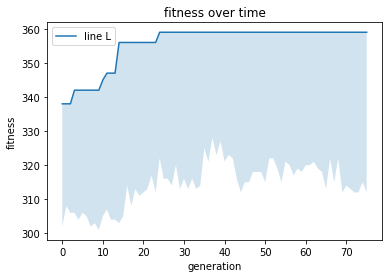

In [1043]:
import matplotlib.pyplot as plt
 
x  = range(len(max_fitnesses))
plt.plot(x, max_fitnesses, label="line L")
plt.fill_between(x, min_fitnesses, max_fitnesses, alpha=0.2)
plt.plot()

plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness over time")
plt.legend()
plt.show()

In [1044]:
#print(population[0])
#print(fitness(population[0]))
#print(population[0])

In [1045]:

recipes = []

graph = defaultdict(list)
replacements = []

ingredient_bag = defaultdict(int)


def parse_ingredient(line):

    line = line.lstrip()
    idx = 0
    # devemos tentar aqui separar as unidades ou simplesmente unidades + elementos são o proprio elemento?
    #while (line[idx].isdigit() or line[idx] == '/' or line[idx] == ' '):
    #    idx+=1
    
    #quantity = line [0 : idx].lstrip()
    
    ingredients = line[idx:].lower()

    ingredients = ingredients.split(' or ')

    for i in range(len(ingredients)):
        ingredients[i] = ingredients[i].lstrip()

    return quantity, ingredients

with open('./data.json') as json_file:
    data = json.load(json_file)
    for p in data:
        recipes.append(p)
        for i in range (len(p['ingredients']) - 1):
            for j in range( i + 1, len(p['ingredients'])):

                quantity, ingredients = parse_ingredient(p['ingredients'][i])
                quantity2, ingredients2 = parse_ingredient(p['ingredients'][j]) 

                if len(ingredients) > 1:
                    replacements.append(ingredients)

                if len(ingredients2) > 1:
                    replacements.append(ingredients2)

                for ing in ingredients:
                    graph[ing] += ingredients2
                    ingredient_bag[ing]+=1

                for ing in ingredients2:
                    graph[ing] += ingredients
                    ingredient_bag[ing]+=1
                


for k, v in ingredient_bag.items():
    print("{}->{}".format(k, v))
#for n in graph:
#    print("{} -> {}".format(n , len(graph[n])))

AttributeError: 'dict' object has no attribute 'lstrip'

In [ ]:
from queue import PriorityQueue

def calculate_distance(graph, ingredient):
    pq = PriorityQueue()
    dist = defaultdict(int)

    pq.put((0, ingredient ))
    dist[ingredient] = 0
    visited = set()

    while not pq.empty():
        u = pq.get()[1]
        for i in graph[u]:
            if i in visited:
                continue
            v = i
            visited.add(i)
            if v not in dist or dist[v] > dist[u] + 1:
                dist[v] = dist[u] + 1
                pq.put((dist[v], v))
    
    return dist



def calculate_distances(graph):   
    dist = {}
    for ingredient in graph:
        dist[ingredient] = calculate_distance(graph, ingredient)

    return dist


In [ ]:
dist = calculate_distances(graph) # act as a cache


In [ ]:
#print(dist.keys())

In [ ]:

def fitness(individual, graph):
    counter = 0
    # the higher the worst

    here = [x['name'] for x in individual['ingredients']]
    H = g.subgraph(here)
    pq = PriorityQueue()
    visited = set()
    for i in range(len(individual['ingredients']) - 1):
        for j in range(i + 1 , len(individual['ingredients'])):
            if i in visited and j in visited:
                continue
            pq.put(dist[individual['ingredients'][i]][individual['ingredients'][j]])

    while not pq.empty():
        u = pq.get()
        counter += u
    return counter +len(nx.minimum_spanning_tree(H).edges)

        
#print(recipes[4])
#print(fitness(recipes[4])) 
#print(fitness(recipes[7]))
